# Classifier with Continuous Actions

**idea:** classifier $c(x, a)$ predicts expected costs for taking an action $a$ when observing $x$

1. Sample from prior $\theta\sim p(\theta)$
2. Get observations from simulator $x\sim p(x|\theta)$
3. Sample actions $a\sim p(a)$
4. Train a neural network
    - feed forward NN with $x$ and $a$ as input
    - trained to predict the expected costs
    - loss L2 loss



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt

from loss_calibration.classifier_continuous import train, build_classifier
from loss_calibration.npe import train_npe
from loss_calibration.loss import StepLoss_weighted
import loss_calibration.toy_example as toy
from loss_calibration.plot import plot_loss, plot_predictions
from loss_calibration.utils import load_data

## Toy Example

#### Toy Example

In [3]:
prior = toy.get_prior()
simulator = toy.get_simulator()

# uniform distribution for actions
def get_action(size:int):
    return torch.randint(0,2, (1,size))

actions = get_action

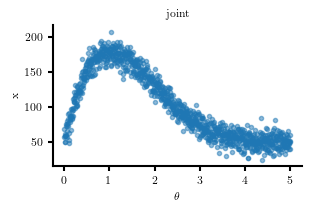

In [4]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(3,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Get data from task

In [5]:
theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
theta_train = theta_train[:50_000]
x_train = x_train[:50_000]
theta_val = theta_val[:5_000]
x_val = x_val[:5_000]
theta_test = theta_test[:5_000]
x_test = x_test[:5_000]

Load data from './data/toy_example', device = cpu.


#### Cost function

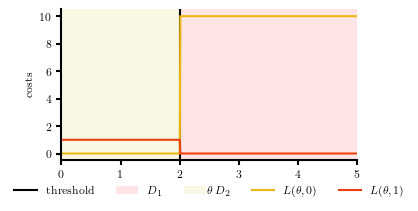

In [6]:
threshold = 2.0
costs = [10.,1.]  
loss = StepLoss_weighted(costs, threshold=threshold)
plot_loss(loss, 0., 5., threshold, resolution=500, xlabel=r"$\theta$", ylabel="costs")

#### Training Data Set

In [7]:
costs_train = torch.concat([loss(theta_train, 0), loss(theta_train, 1)])
actions_train = torch.concat([torch.zeros((theta_train.shape[0],1)),torch.ones((theta_train.shape[0],1))])
theta_train = theta_train.repeat(2,1)
x_train = x_train.repeat(2,1)

costs_val = torch.concat([loss(theta_val, 0), loss(theta_val, 1)])
actions_val = torch.concat([torch.zeros((theta_val.shape[0],1)),torch.ones((theta_val.shape[0],1))])
theta_val = theta_val.repeat(2,1)
x_val = x_val.repeat(2,1)

costs_test = torch.concat([loss(theta_test, 0), loss(theta_test, 1)])
actions_test = torch.concat([torch.zeros((theta_test.shape[0],1)),torch.ones((theta_test.shape[0],1))])
theta_test = theta_test.repeat(2,1)
x_test = x_test.repeat(2,1)


#### Classifier

In [8]:
torch.manual_seed(8639)

clf = build_classifier("fc", x_train, actions_train, hidden_dims=[50,50,50], output_dim=1, activation=nn.ReLU(), output_transform=nn.Identity())
print(clf, end="\n-----\n")

clf, train_loss, val_loss = train(
    clf,
    x_train,
    actions_train,
    costs_train,
    x_val,
    actions_val,
    costs_val,
    learning_rate=1e-3,
    model_dir="./results/continuous/toy_example",
    max_num_epochs=800,
    stop_after_epochs=30,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Identity()
)
-----
Converged after 58 epochs. train_loss = 3.49614178	 last_improvement = 12


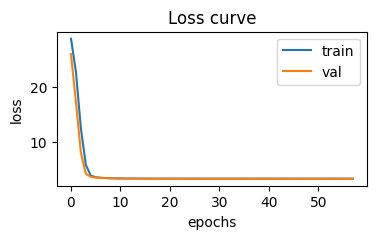

In [9]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.show()

##### Check predictions on training data

In [10]:
predictions_train = clf(x_train, actions_train)

In [11]:
losses_train = torch.mean((costs_train - predictions_train)**2, dim=1)
torch.median(losses_train), torch.mean(losses_train)

(tensor(0.0240, grad_fn=<MedianBackward0>),
 tensor(3.4953, grad_fn=<MeanBackward0>))

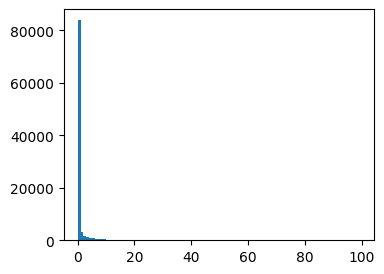

In [12]:
plt.figure(figsize=(4,3))
plt.hist(losses_train.detach().numpy(), bins=100)
plt.show()

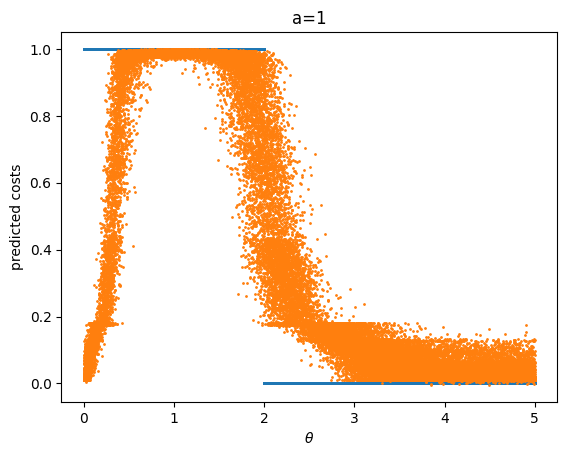

In [13]:
a = 1
cond = actions_train== a
plt.scatter(theta_train[cond].numpy().squeeze(), costs_train[cond].detach().numpy().squeeze(), s=1)
plt.scatter(theta_train[cond].numpy().squeeze(), predictions_train[cond].detach().numpy().squeeze(), s=1)
plt.title(f'a={a}')
plt.xlabel(r'$\theta$')
plt.ylabel('predicted costs')
plt.show()

##### Check posterior ratios on training data

In [14]:
ratios_train_posterior = torch.as_tensor([toy.posterior_ratio(x, costs=costs, threshold=threshold) for x in x_train]).unsqueeze(1)
preds_train_0 = clf(x_train, torch.zeros_like(actions_train))
preds_train_1 = clf(x_train, torch.ones_like(actions_train))
ratios_clf_train = preds_train_0/(preds_train_0+preds_train_1)

In [15]:
ratios_train_posterior

tensor([[0.9974],
        [0.9969],
        [0.9959],
        ...,
        [0.0143],
        [0.9969],
        [0.9980]])

In [16]:
ratios_clf_train

tensor([[0.9990],
        [0.9985],
        [0.9964],
        ...,
        [0.0516],
        [0.9986],
        [0.9981]], grad_fn=<DivBackward0>)

In [17]:
preds_train_0[:10]

tensor([[9.7890],
        [9.6750],
        [9.5273],
        [8.3727],
        [8.9218],
        [0.0155],
        [9.5075],
        [9.8477],
        [0.0207],
        [7.7723]], grad_fn=<SliceBackward0>)

In [18]:
preds_train_1[:10]

tensor([[0.0094],
        [0.0141],
        [0.0341],
        [0.1761],
        [0.1281],
        [0.9931],
        [0.0377],
        [0.0144],
        [0.9868],
        [0.1781]], grad_fn=<SliceBackward0>)

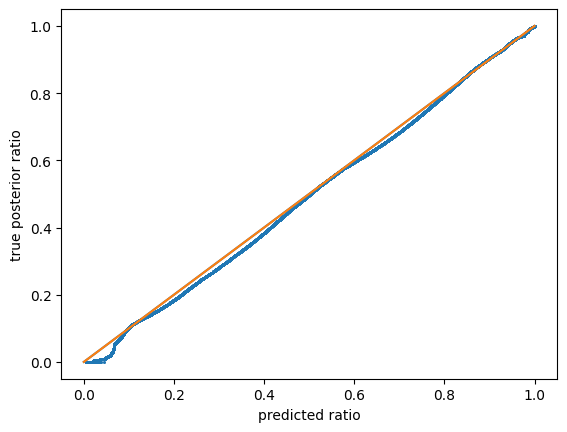

In [19]:
plt.plot([(0,0), (1,1)])
plt.scatter(ratios_clf_train.detach().numpy(), ratios_train_posterior.numpy(), s=1)
plt.xlabel("predicted ratio")
plt.ylabel("true posterior ratio")
#plt.savefig("results/toy_example/fig_continuous_clf_ratios.png")
plt.show()

Note: some predicted costs of the NN seem to be negative, closer check: this is only the case for a=0

In [20]:
ratios_clf_train[ratios_clf_train<0].shape

torch.Size([0])

In [21]:
(clf(x_train, torch.ones_like(actions_train))[ratios_clf_train<0] < 0).any()

tensor(False)

In [22]:
(clf(x_train, torch.zeros_like(actions_train))[ratios_clf_train<0] < 0).all()

tensor(True)

In [23]:
clf(x_train, torch.zeros_like(actions_train))[ratios_clf_train<0]

tensor([], grad_fn=<IndexBackward0>)

##### Check predictions on test data

In [24]:
predictions_test = clf(x_test, actions_test)

In [25]:
losses_test = torch.mean((costs_test - predictions_test)**2, dim=1)
torch.median(losses_test), torch.mean(losses_test)

(tensor(0.0240, grad_fn=<MedianBackward0>),
 tensor(3.4403, grad_fn=<MeanBackward0>))

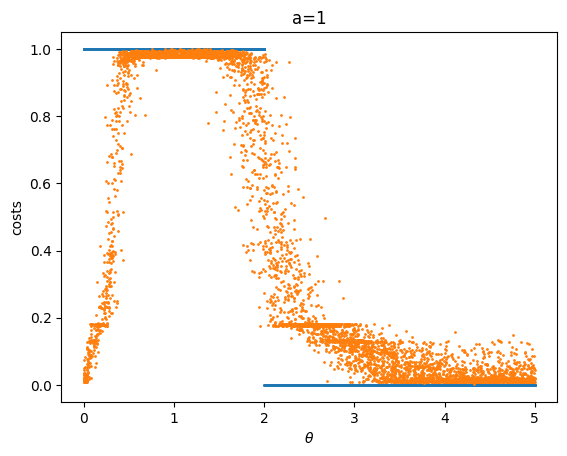

In [26]:
a = 1
cond_test = actions_test== a
plt.scatter(theta_test[cond_test].numpy().squeeze(), costs_test[cond_test].detach().numpy().squeeze(), s=1)
plt.scatter(theta_test[cond_test].numpy().squeeze(), predictions_test[cond_test].detach().numpy().squeeze(), s=1)
plt.title(f'a={a}')
plt.xlabel(r'$\theta$')
plt.ylabel('costs')
plt.show()

##### Check posterior ratios on test data

In [27]:
ratios_test_posterior = torch.as_tensor([toy.posterior_ratio(x, costs=costs, threshold=threshold) for x in x_test]).unsqueeze(1)
ratios_clf_test = clf(x_test, torch.zeros_like(actions_test))/(clf(x_test, torch.zeros_like(actions_test)) + clf(x_test, torch.ones_like(actions_test)))

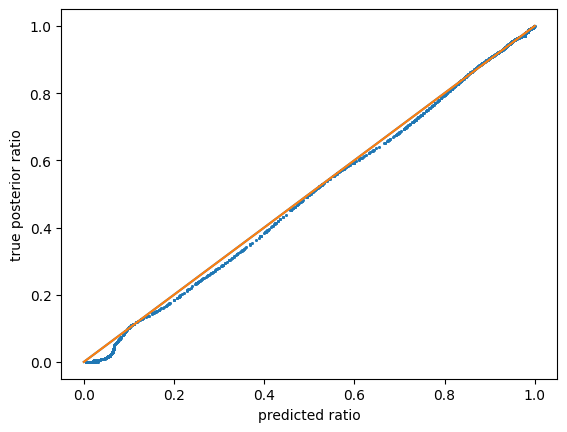

In [28]:
plt.plot([(0,0), (1,1)])
plt.scatter(ratios_clf_test.detach().numpy(), ratios_test_posterior.numpy(), s=1)
plt.xlabel("predicted ratio")
plt.ylabel("true posterior ratio")
plt.show()